In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, os.path

SIM_DATAROOT = os.path.join(os.getenv('AIGRAIN_ROTATION'), 'final')

Let's start exploring using the Aigrain et al. simulated data.  Here's a few example light curves:

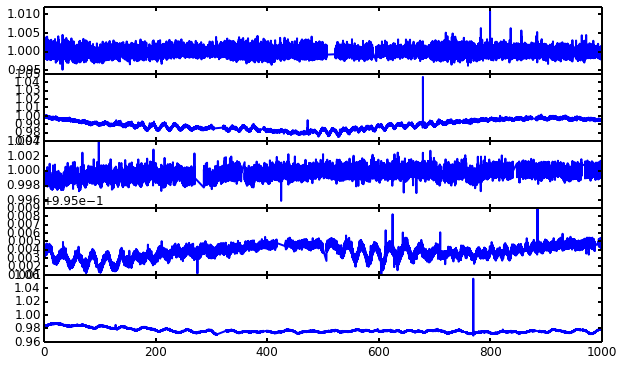

In [33]:
def get_aigrain_data(i, f_err=0.0001, npts=None, binpts=None):
    filename = os.path.join(SIM_DATAROOT, 'lightcurve_{:04.0f}.txt'.format(idx))
    ts, fs = np.loadtxt(filename, unpack=True)
    f_err = np.ones_like(fs) * f_err
    
    if binpts is not None:
        ts, fs, ferr = bin_data(ts, fs, f_err, binpts)
    if npts is None:
        return ts, fs, f_err
    else:
        return ts[:npts], fs[:npts], f_err[:npts]

def bin_data(x, y, yerr, npts):
    mod, nbins = len(x) % npts, len(x) / npts
    if mod != 0:
        x, y, yerr = x[:-mod], y[:-mod], yerr[:-mod]
    xb, yb, yerrb = [np.zeros(nbins) for i in range(3)]
    for i in range(npts):
        xb += x[::npts]
        yb += y[::npts]
        yerrb += yerr[::npts]**2
        x, y, yerr = x[1:], y[1:], yerr[1:]
    return xb/npts, yb/npts, yerrb**.5/npts    
    
idxs = [0,100,200,300,400]
fig,axes = plt.subplots(len(idxs), 1, figsize=(10,6), sharex=True, )
for i,idx in enumerate(idxs):
    ts, fs, f_errs = get_aigrain_data(idx)
    axes[i].plot(ts,fs)
plt.subplots_adjust(hspace=0.0001)

In [20]:
len(ts)

44996

OK, so these light curves have ~45000 points.  Let's set up a GP likelihood and see how long an evaluation of this takes on a subset of the data.  Here doing a sum of a squared-exponential and the rotation kernel.

In [56]:
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel, Matern32Kernel

def lnlike(theta, t, f, f_err):
    """
    The log-likelihood function.
    Uses a squared exponential times an exponential-sine
    kernel function.
    theta is the array of parameters:
    theta = [A2, gamma, l2, sigma, period, A1, l1]
    
    A1 = amplitude of matern-3/2 kernel
    l1 = length scale of the matern kernel
    
    A2 = amplitude of quasiperiodic kernel.
    gamma = scaling factor in the exponential-sine kernel.
    l2 = length scale of the squared-exponential kernel 
    sigma = white noise multiplier
    period = period (obv). In the same units as your 'xs'.

    """

    #theta = np.exp(theta)
    k1 = theta[0] * ExpSquaredKernel(theta[1]) \
            * ExpSine2Kernel(theta[2], theta[4])
    k2 = theta[5] * Matern32Kernel(theta[6])
    gp = george.GP(k1 + k2)
    try:
        gp.compute(t, np.sqrt(theta[3]+ f_err**2))
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    return gp.lnlikelihood(f, quiet=True)

t, f, f_err = get_aigrain_data(400, npts=2000)

theta = [0.01, 1., 1., 0.0001, 10., 0.01, 1.]
%timeit lnlike(theta, t, f, f_err)
%timeit lnlike(theta, t[:1000], f[:1000], f_err[:1000])
%timeit lnlike(theta, t[:500], f[:500], f_err[:500])

1 loops, best of 3: 662 ms per loop
10 loops, best of 3: 137 ms per loop
10 loops, best of 3: 28.5 ms per loop


OK, brutal.  6 seconds for a likelihood evaluation with only 2000 points.  But this drops significantly; only 0.1s for 1000 points, and another factor of 5 for 500 pts.  Maybe we can do it in chunks and win a bit?  Or both bin & do in chunks?  A reasonable minimum rotation period to look for might be on the order of 1 day, and cadence is ~0.02 days, so what about binning 5 points at a time?

In [43]:
t, f, f_err = get_aigrain_data(400, npts=2000, binpts=5)
%timeit lnlike(theta, t, f, f_err)

1 loops, best of 3: 2.15 s per loop


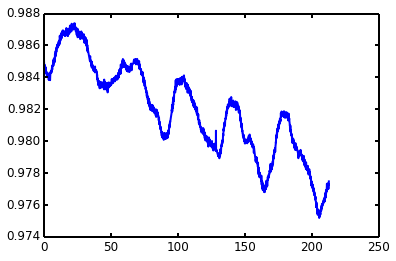

In [44]:
plt.plot(t, f)

Crazy idea: what about just randomly sampling N points from the light curve and evaluating GP model at those, and then changing the sampling at each lhood evaluation?  Is there any justification for this being possibly valid at all?

1 loops, best of 3: 235 ms per loop


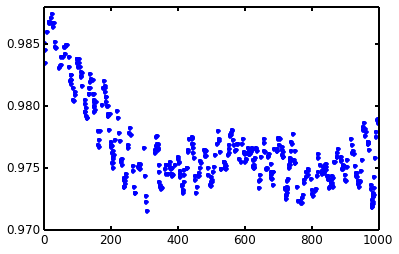

In [57]:
i = 300
t, f, f_err = get_aigrain_data(i)
Npts = 500
inds = np.random.randint(len(t), size=Npts)
%timeit lnlike(theta, t[inds], f[inds], f_err[inds])
plt.plot(t[inds], f[inds], '.');

OK, let's make up a "likelihood function" along this line, and let's see if we can optimize it!

In [ ]:
def lnlike_bootstrap(theta, t, f, f_err, Npts=500):
    inds = np.random.randint(len(t), size=Npts)
    return lnlike(theta, t[inds], f[inds], f_err[inds])

